In [10]:
import pandas as pd, numpy as np
import seaborn as sns
import torch
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from skimage.color import rgb2gray
from skimage.filters import sobel, scharr, apply_hysteresis_threshold, gaussian
from skimage.feature import canny
from skimage.measure import regionprops,regionprops_table
from skimage.morphology import binary_opening, disk, binary_closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter
from sklearn.model_selection import train_test_split
from scipy.ndimage import label as scilabel
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib; matplotlib.rcParams['figure.dpi']=300

sps=pd.read_pickle("specimens_toy_data.pkl")

In [11]:
df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])

    #["nc_ratio"]

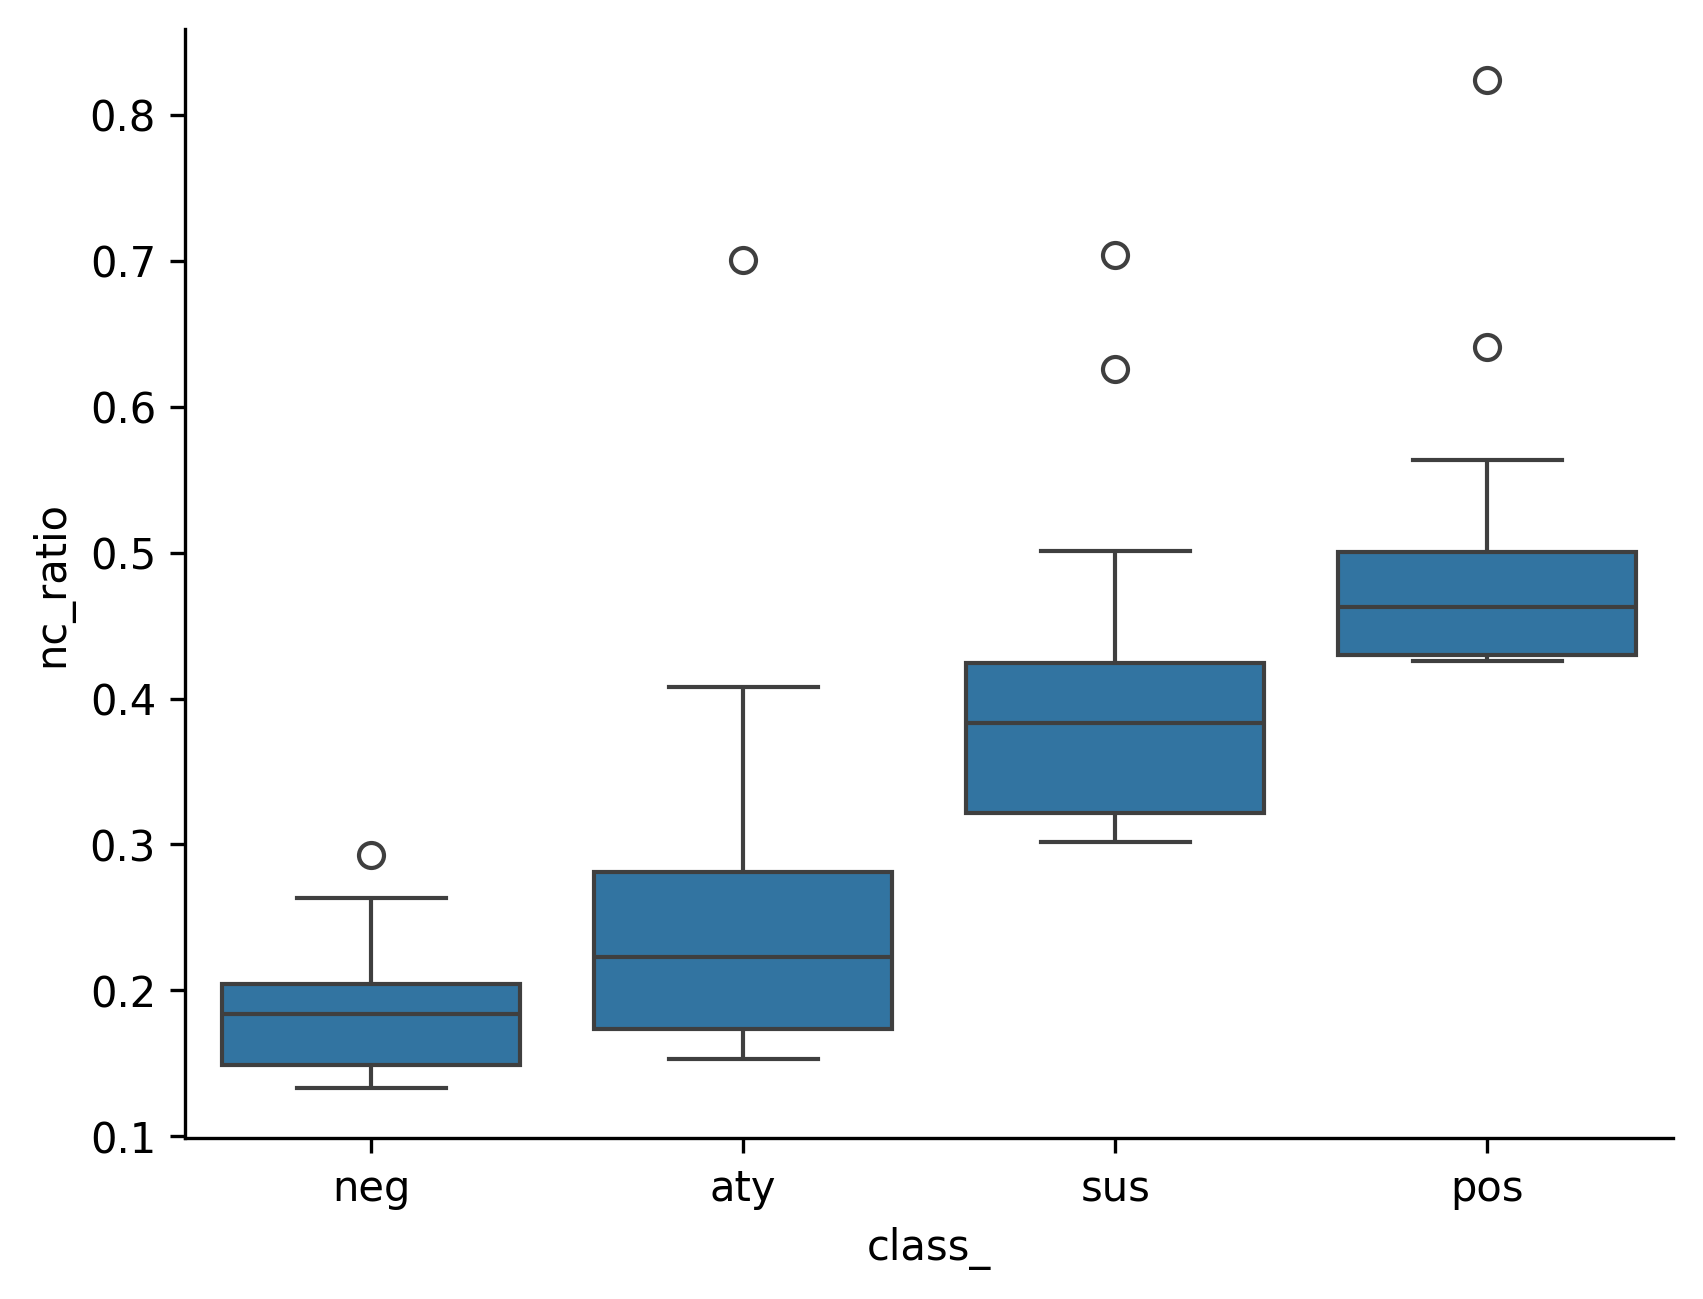

In [12]:
sns.boxplot(x="class_",y="nc_ratio",data=df)
sns.despine()

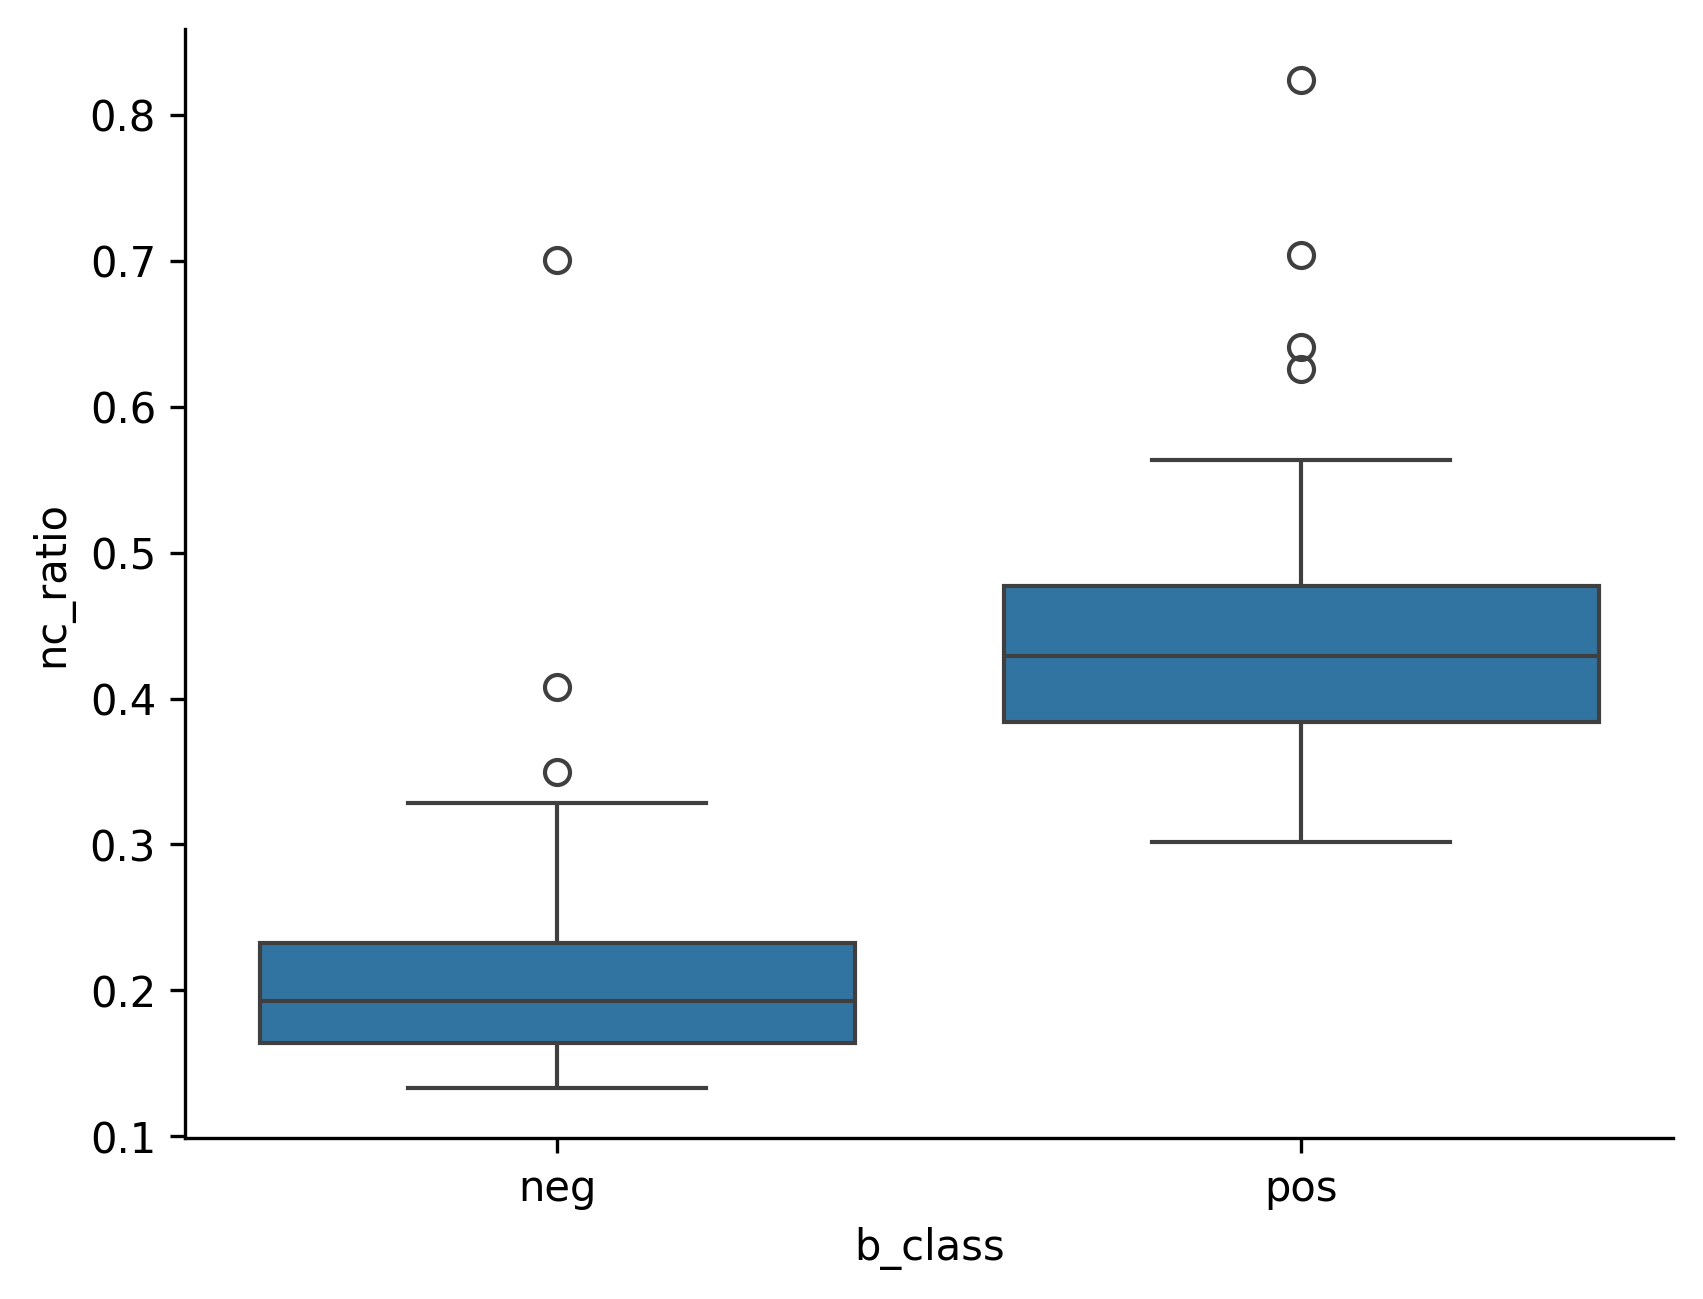

In [13]:
df["b_class"]  = df["class_"].map(lambda x: "pos" if x in ["pos", "sus"] else "neg")
sns.boxplot(x="b_class",y="nc_ratio",data=df)
sns.despine()

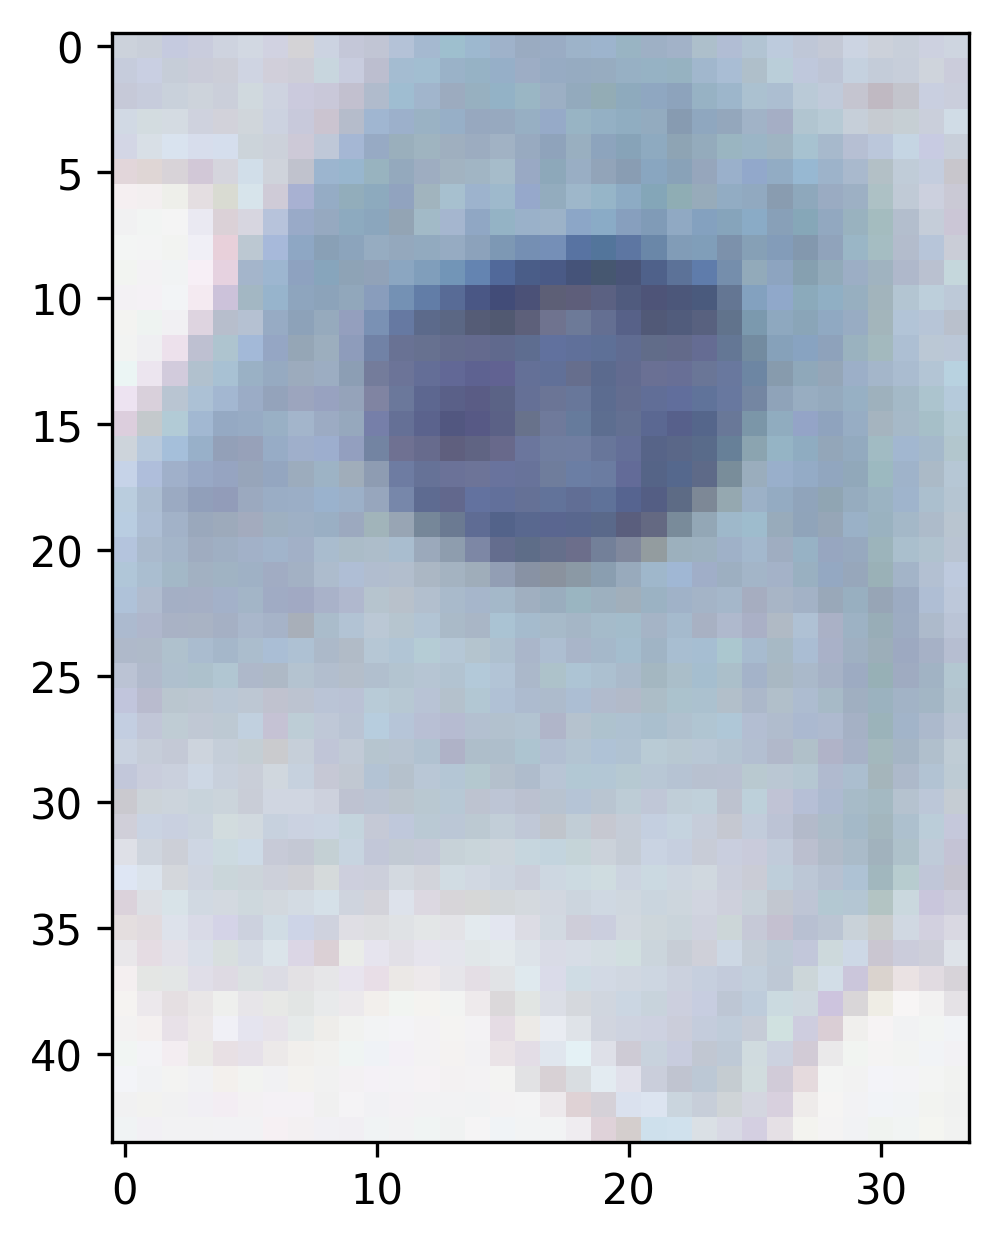

In [14]:
plt.imshow(sps["neg"]["imgs"][0])

In [15]:
from functools import reduce
resize = lambda x: cv2.resize(x,(256,256),interpolation=cv2.INTER_CUBIC)
all_images=reduce(lambda x,y: x+y,[list(map(resize,sps[k]["imgs"])) for k in sps])

In [16]:
# describes above images, assess performance for NC ratio, class assignment, etc
df.head(df.shape[0])

,aty,nc_ratio,nuclear_area,cyto_area,class_,b_class
0,0.057022,0.141928,7221.0,43657.0,neg,neg
1,0.037513,0.175625,7597.0,35660.0,neg,neg
2,0.056971,0.150782,7442.0,41914.0,neg,neg
3,0.077020,0.182437,8177.0,36644.0,neg,neg
4,0.111039,0.183712,8696.0,38639.0,neg,neg
...,...,...,...,...,...,...
20,0.143248,0.359070,16533.0,29511.0,sus,pos
21,0.079847,0.304277,14783.0,33801.0,sus,pos
22,0.519353,0.424544,21172.0,28698.0,sus,pos
23,0.498367,0.386391,15150.0,24059.0,sus,pos


In [17]:
print(df)

         aty  nc_ratio  nuclear_area  cyto_area class_ b_class
0   0.057022  0.141928        7221.0    43657.0    neg     neg
1   0.037513  0.175625        7597.0    35660.0    neg     neg
2   0.056971  0.150782        7442.0    41914.0    neg     neg
3   0.077020  0.182437        8177.0    36644.0    neg     neg
4   0.111039  0.183712        8696.0    38639.0    neg     neg
..       ...       ...           ...        ...    ...     ...
20  0.143248  0.359070       16533.0    29511.0    sus     pos
21  0.079847  0.304277       14783.0    33801.0    sus     pos
22  0.519353  0.424544       21172.0    28698.0    sus     pos
23  0.498367  0.386391       15150.0    24059.0    sus     pos
24  0.226941  0.327733       14786.0    30330.0    sus     pos

[100 rows x 6 columns]


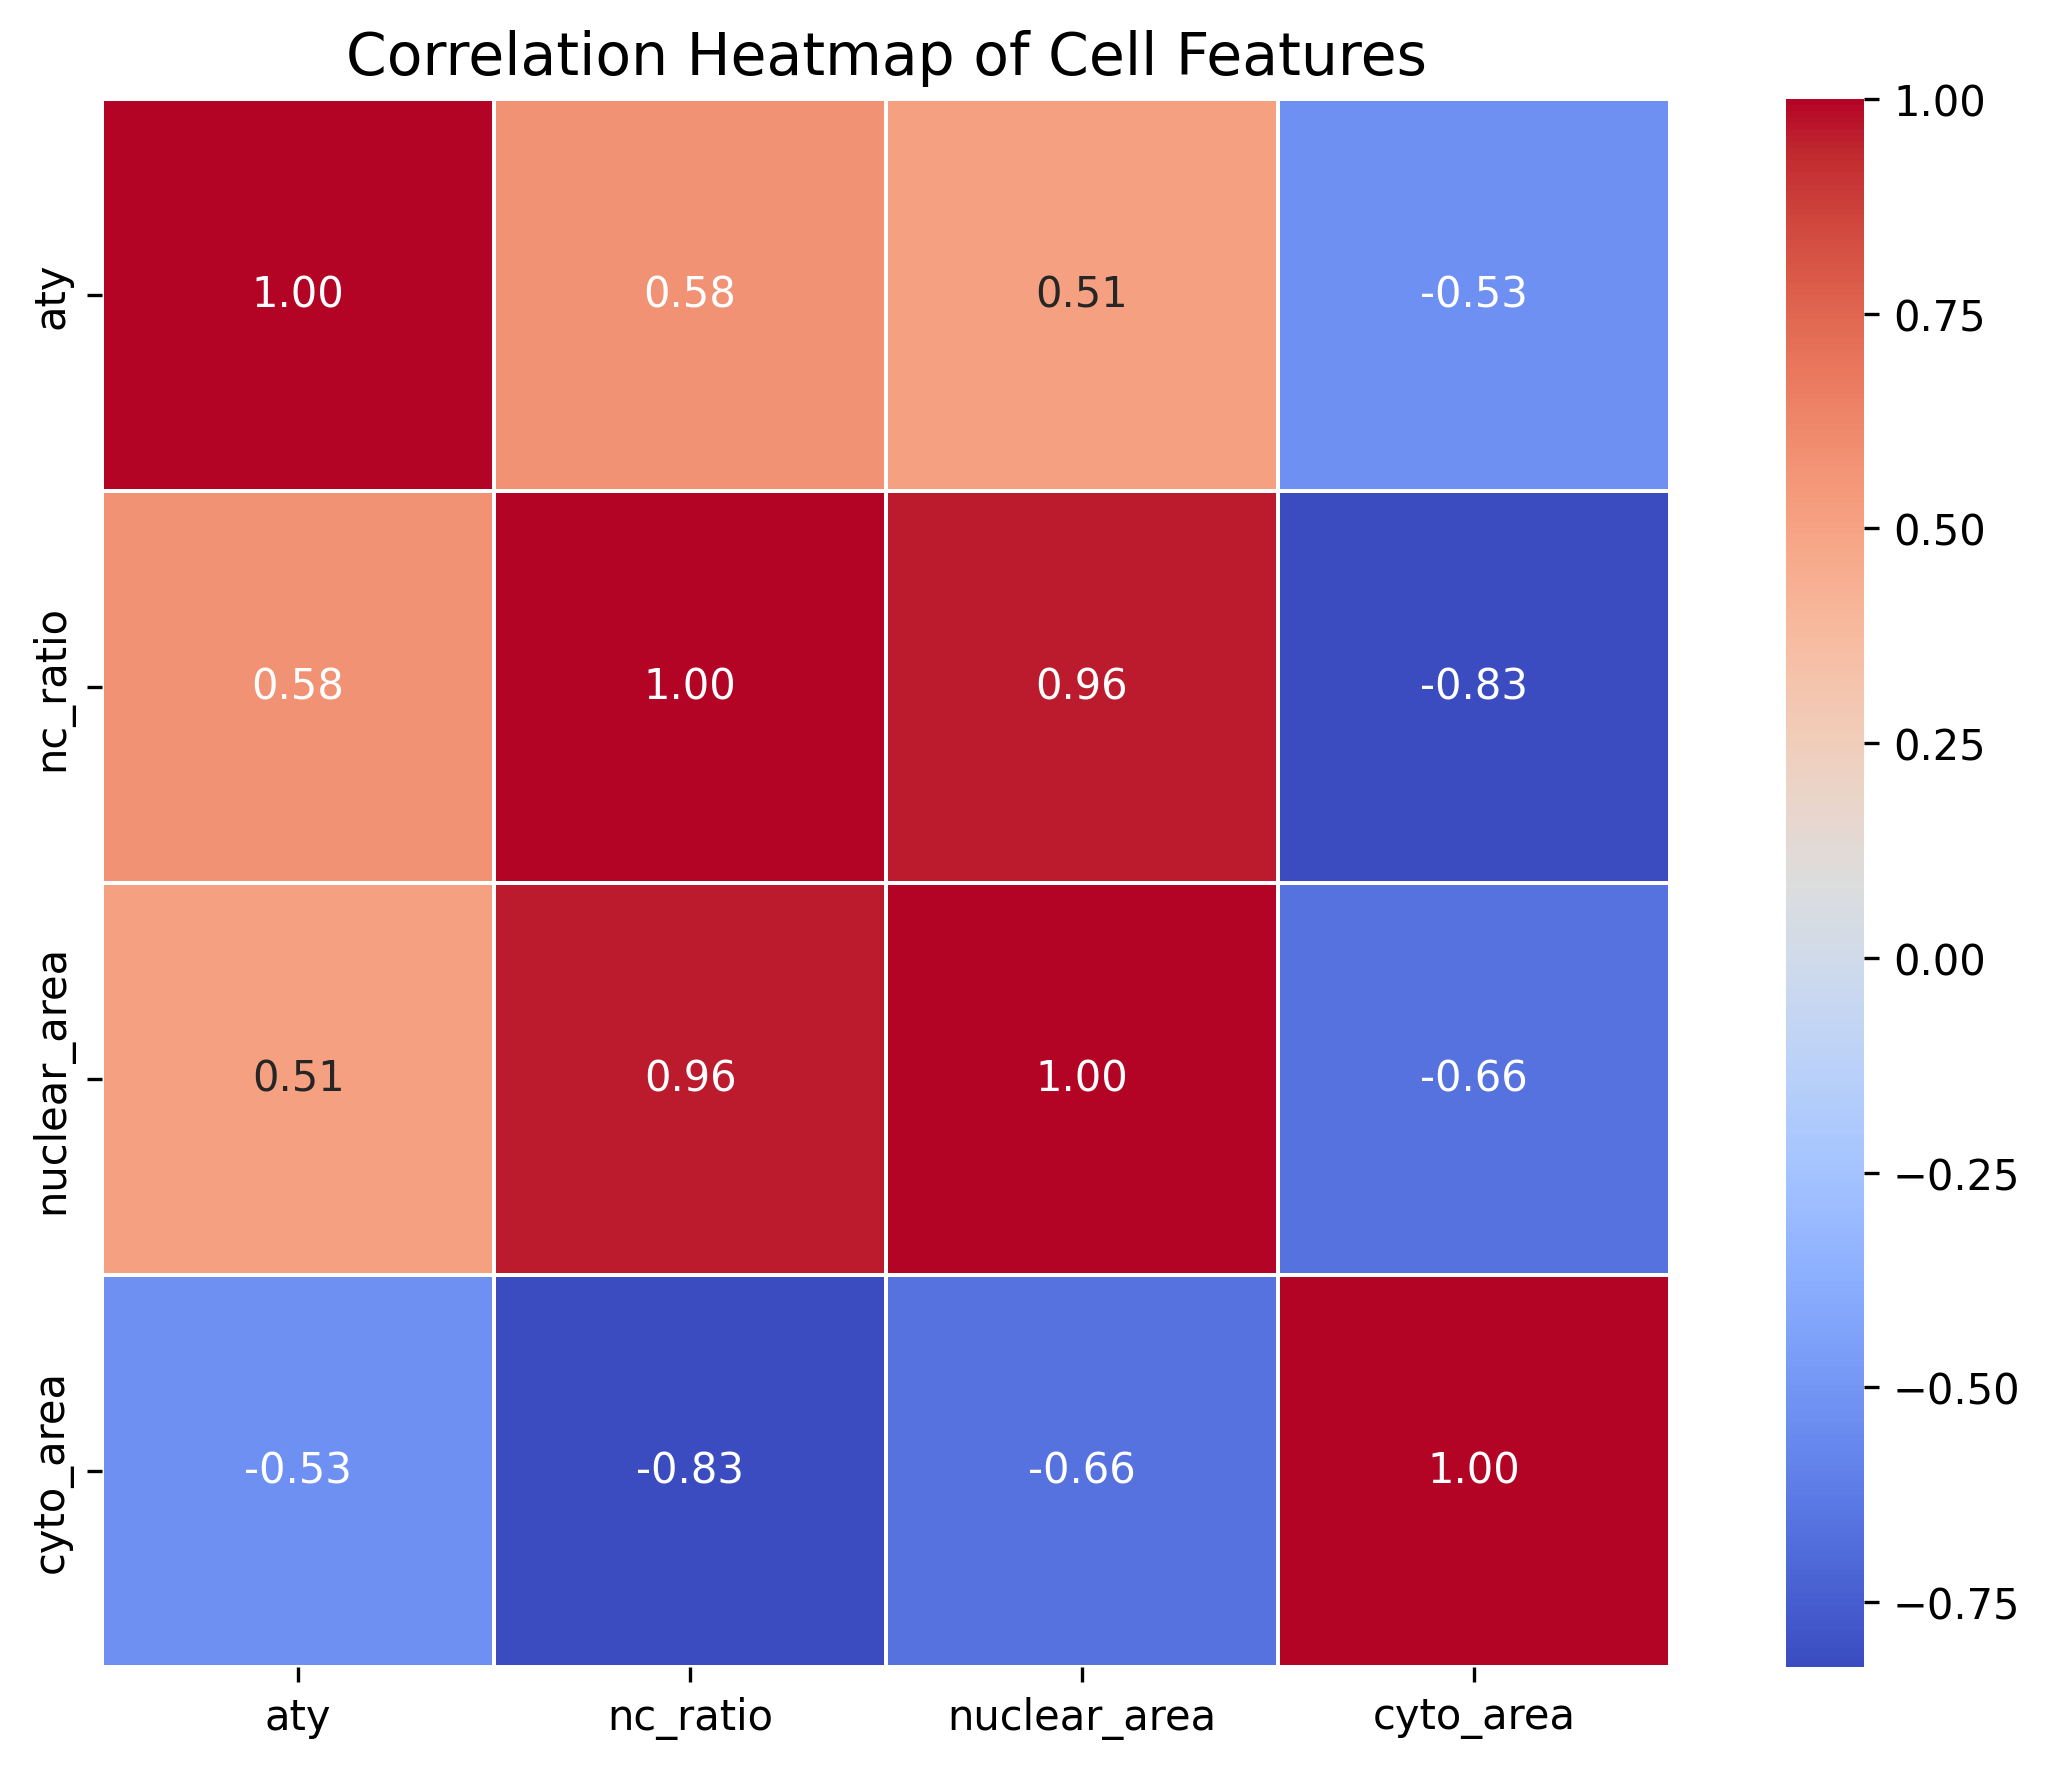

In [18]:
# Compute the correlation matrix for numeric columns
corr = df.drop(columns=['class_','b_class']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Cell Features', fontsize=14)

plt.tight_layout()
plt.show()

In [19]:
print(sps.keys())
#print nested keys
print(sps["neg"].keys())
#print shape of imgs
print(sps["neg"]["imgs"][0].shape)
#for all classes
for k in sps:
    print(f"{k} has {len(sps[k]['imgs'])} images")
#print keys for metadata
print(sps["neg"]["metadata"].keys())
#check if classes have keys
print(sps["neg"]["metadata"]["nc_ratio"].keys())

dict_keys(['neg', 'pos', 'aty', 'sus'])
dict_keys(['imgs', 'metadata'])
(44, 34, 3)
neg has 25 images
pos has 25 images
aty has 25 images
sus has 25 images
Index(['aty', 'nc_ratio', 'nuclear_area', 'cyto_area'], dtype='object')
RangeIndex(start=0, stop=25, step=1)


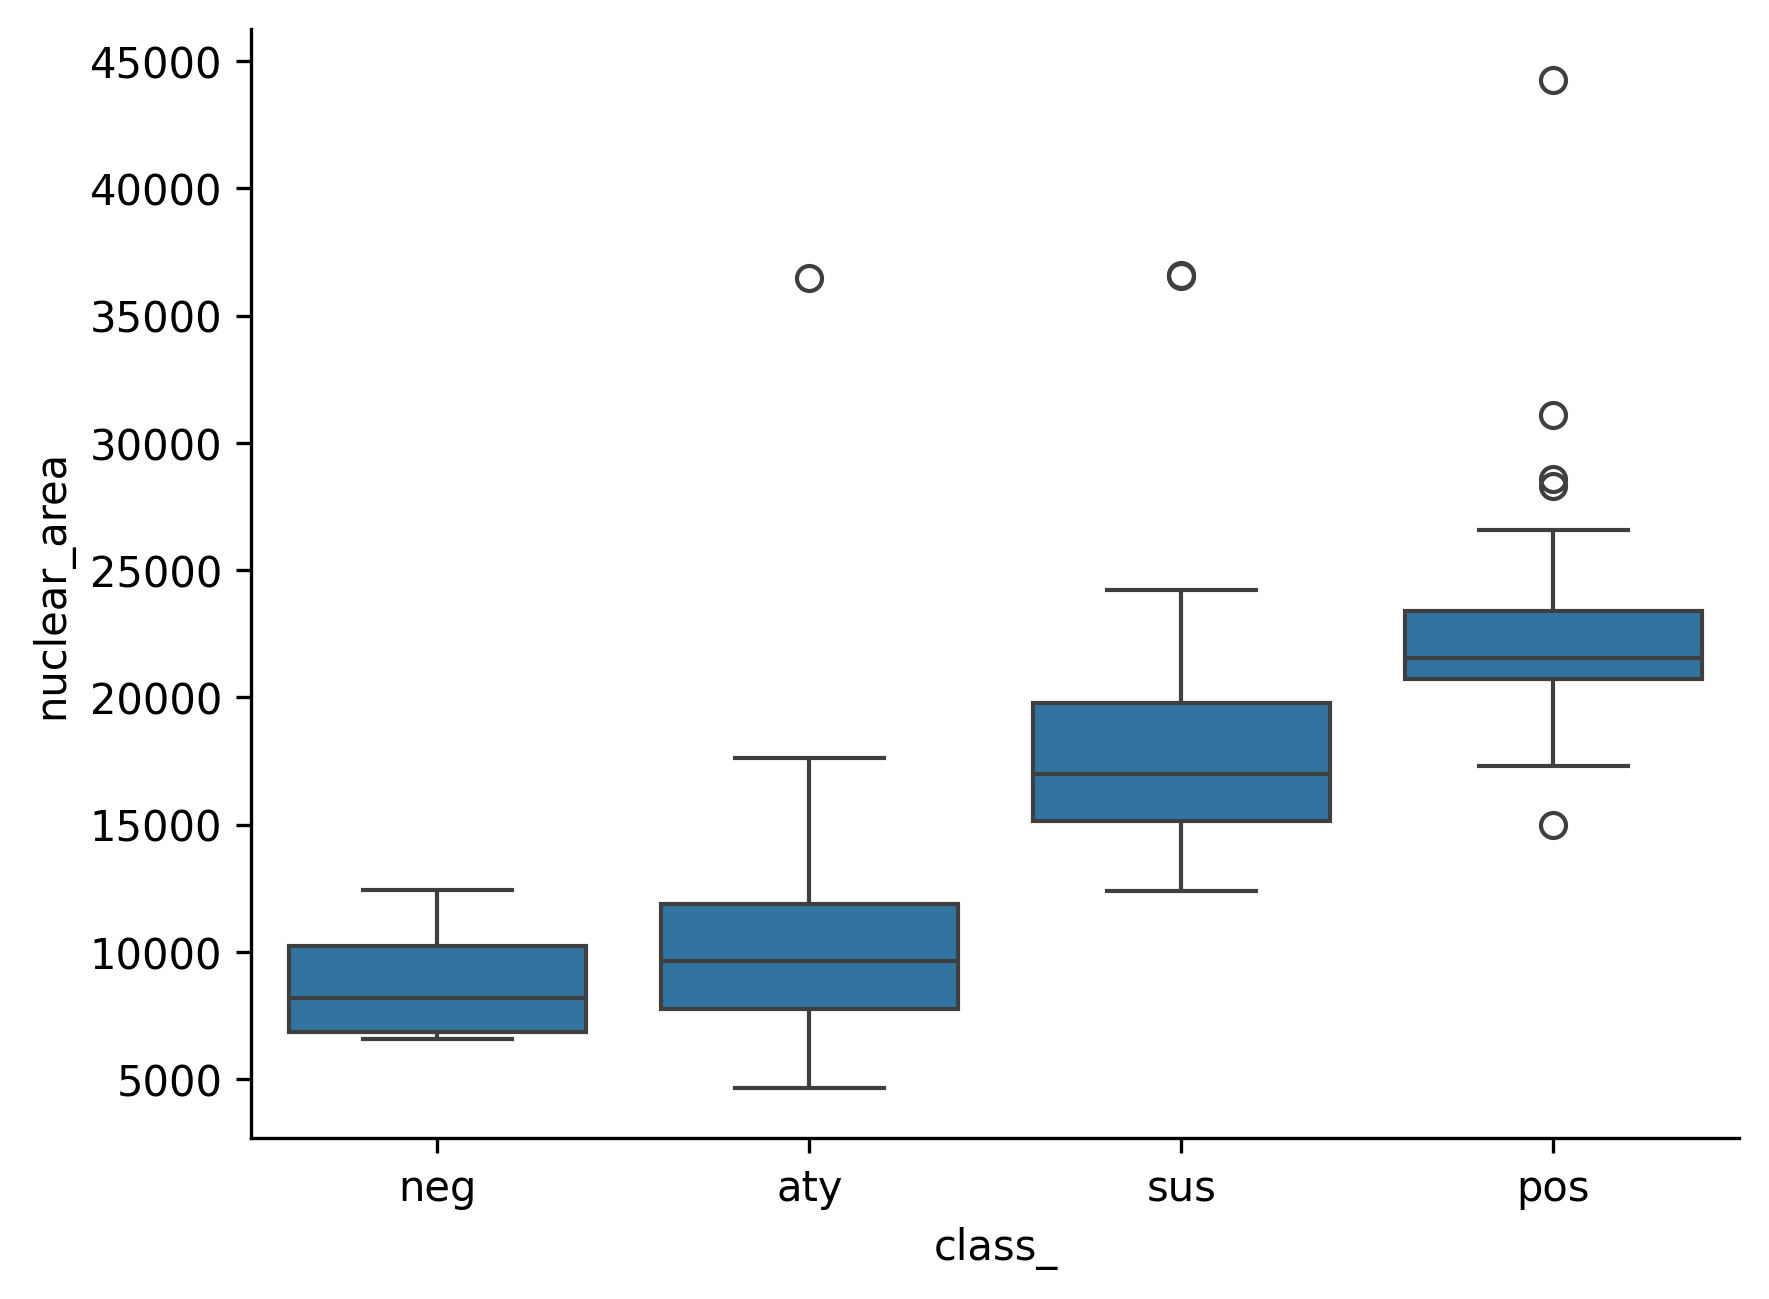

In [20]:
sns.boxplot(x="class_",y="nuclear_area",data=df)
sns.despine()

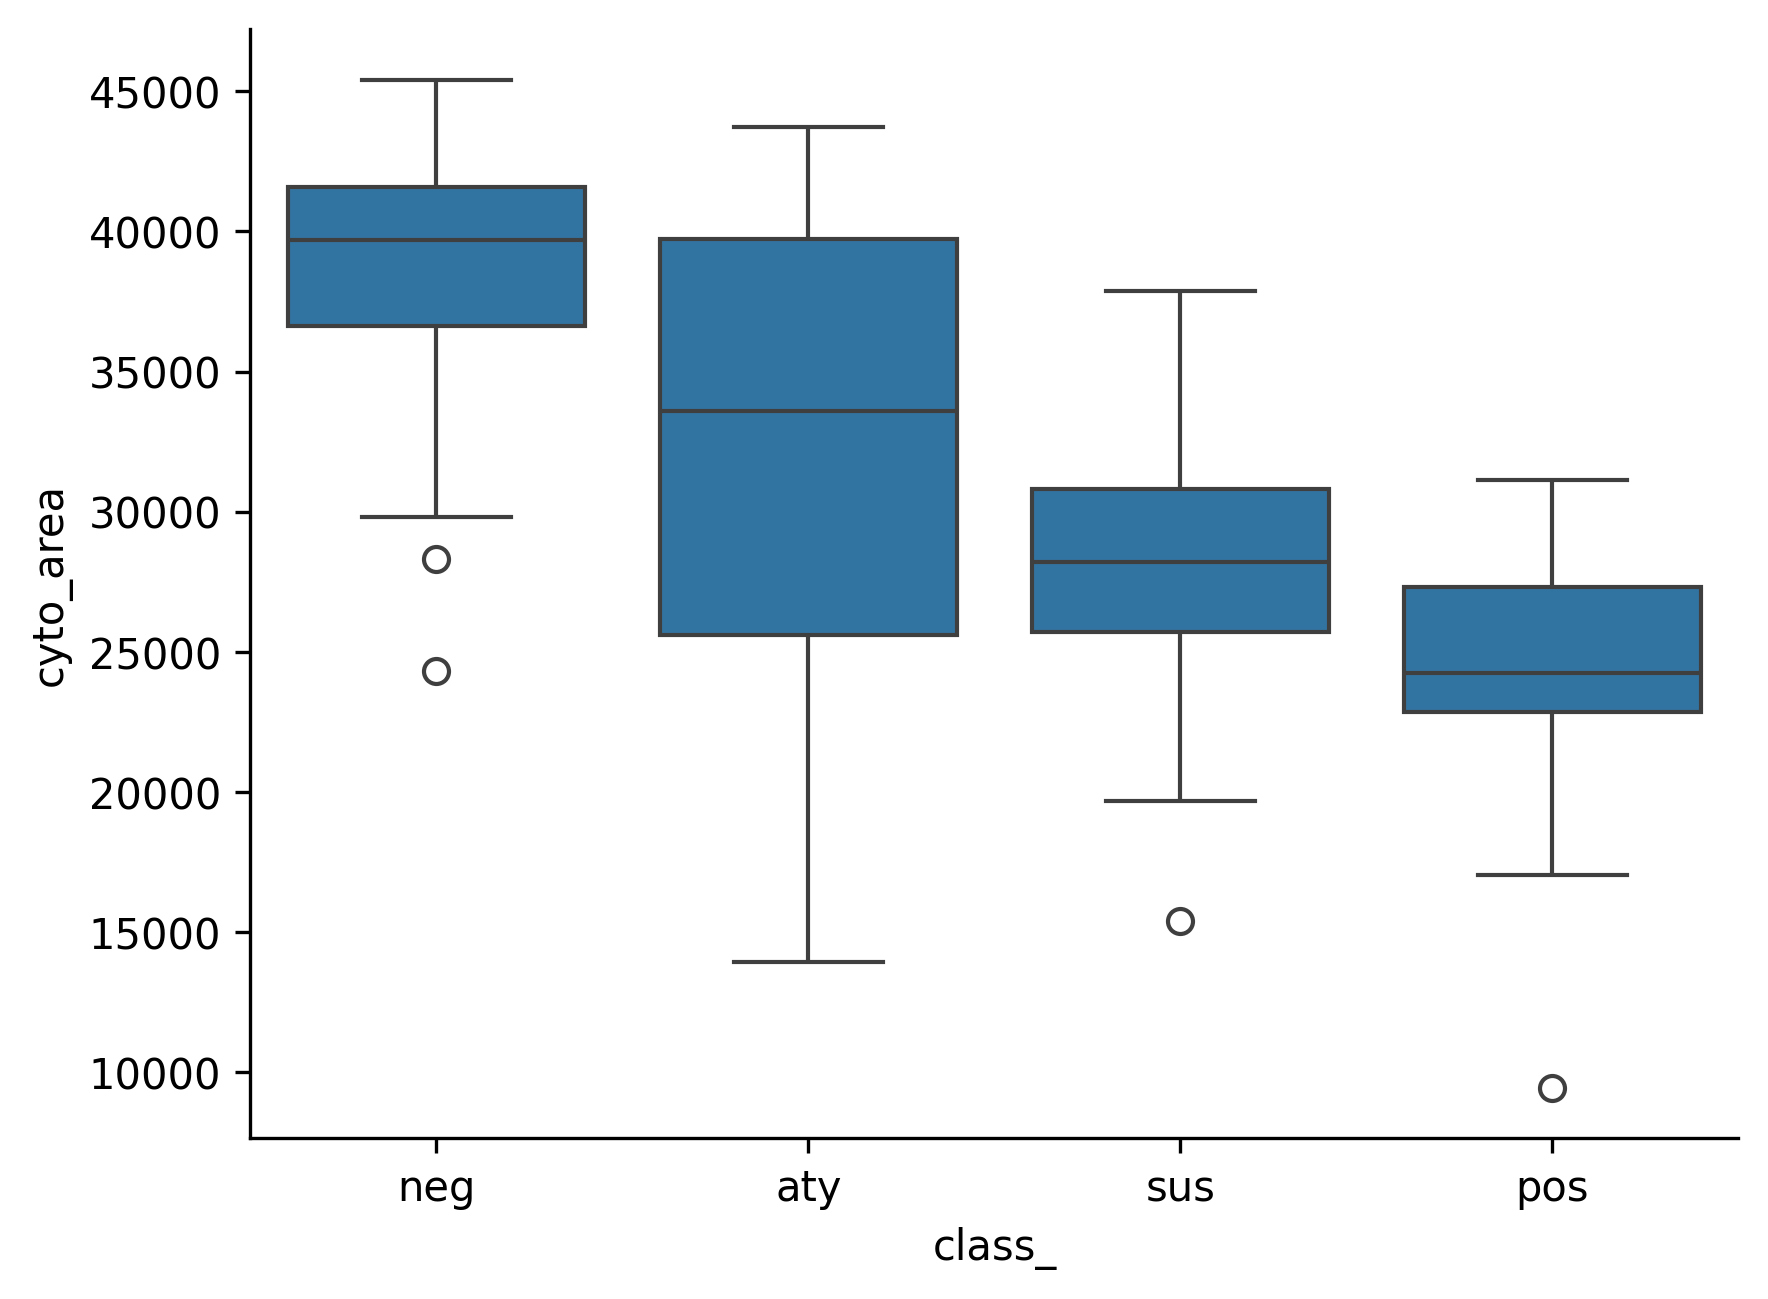

In [21]:
sns.boxplot(x="class_",y="cyto_area",data=df)
sns.despine()

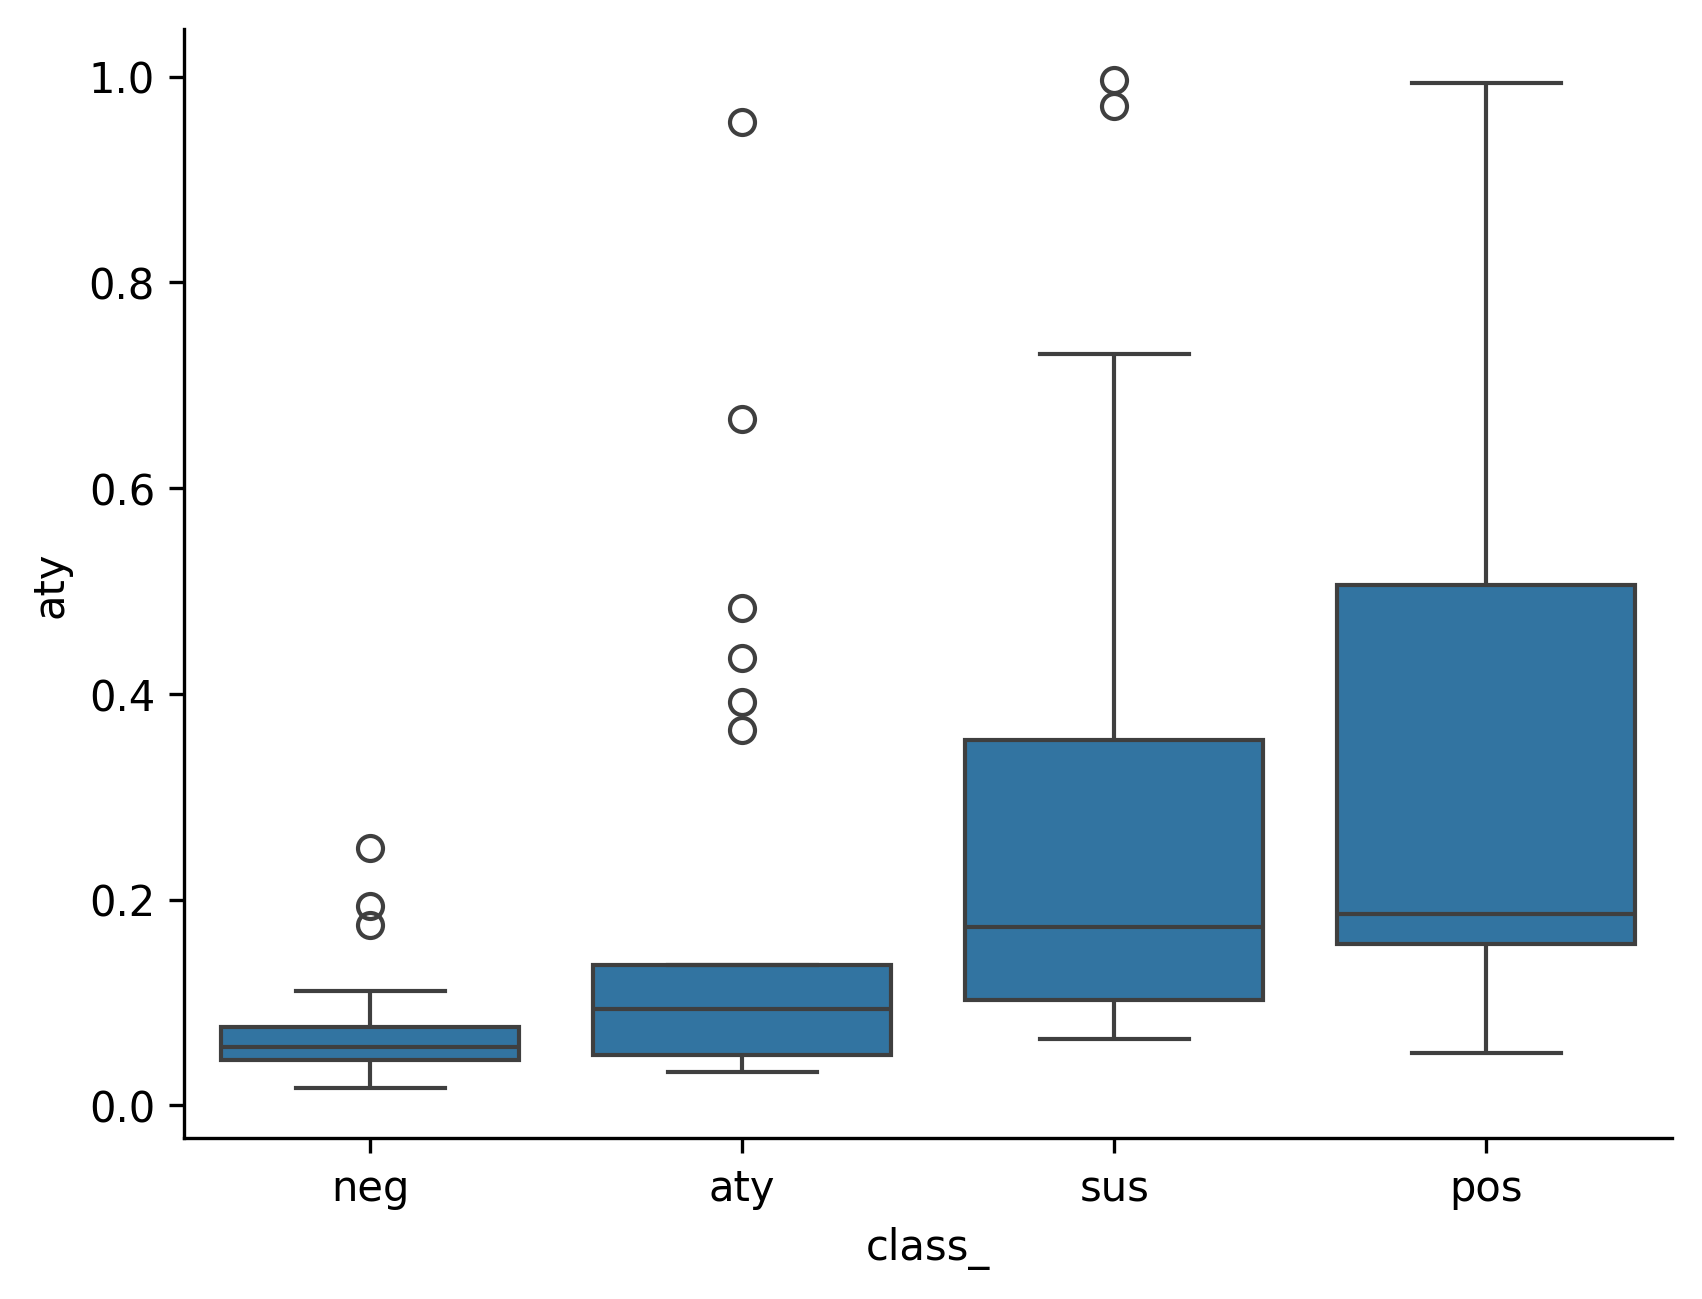

In [22]:
sns.boxplot(x="class_",y="aty",data=df)
sns.despine()

In [23]:
df["nc_ratio"].describe()

count    100.000000
mean       0.330243
std        0.149322
min        0.133238
25%        0.193307
50%        0.313231
75%        0.430142
max        0.824038
Name: nc_ratio, dtype: float64

<Axes: xlabel='nc_ratio', ylabel='Count'>

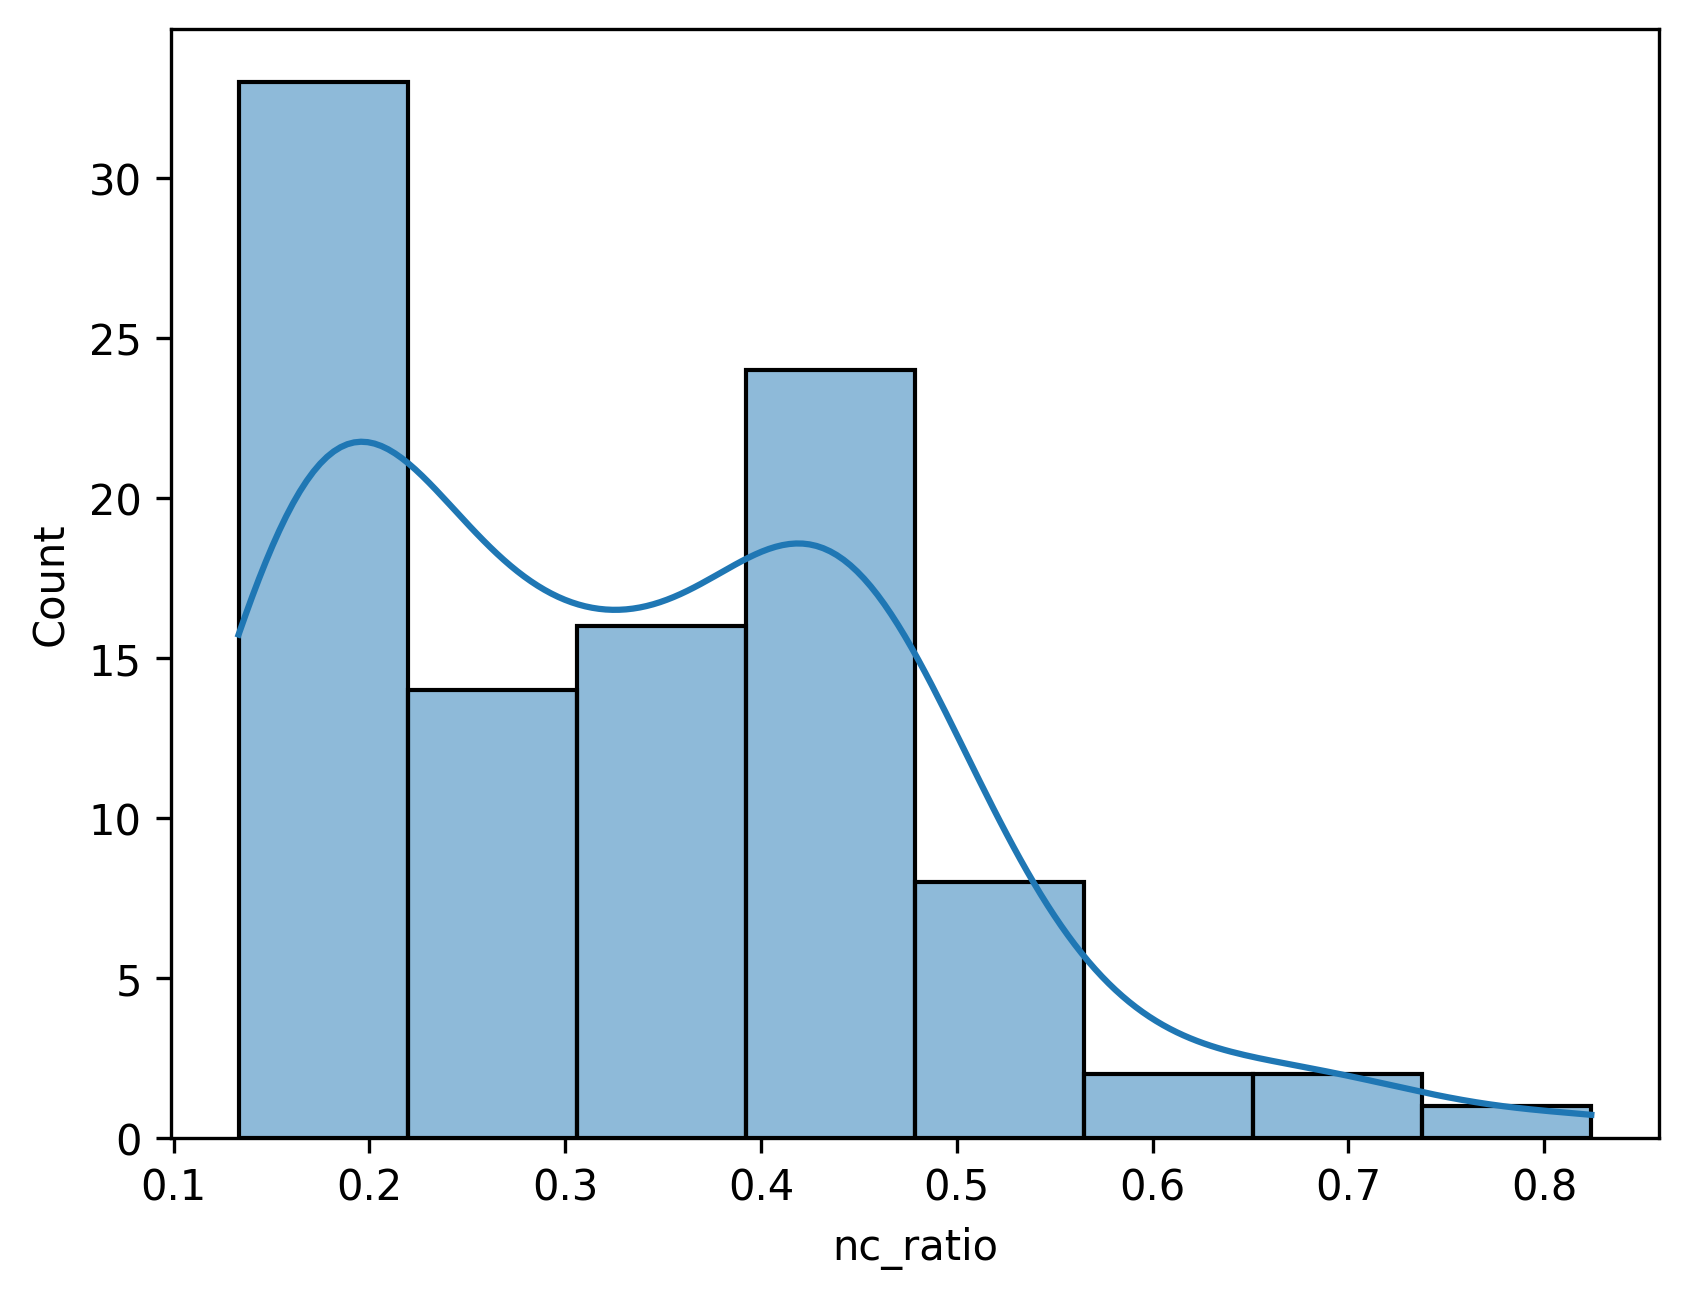

In [24]:
import seaborn as sns
sns.histplot(df["nc_ratio"], kde=True)


<Axes: xlabel='nc_ratio'>

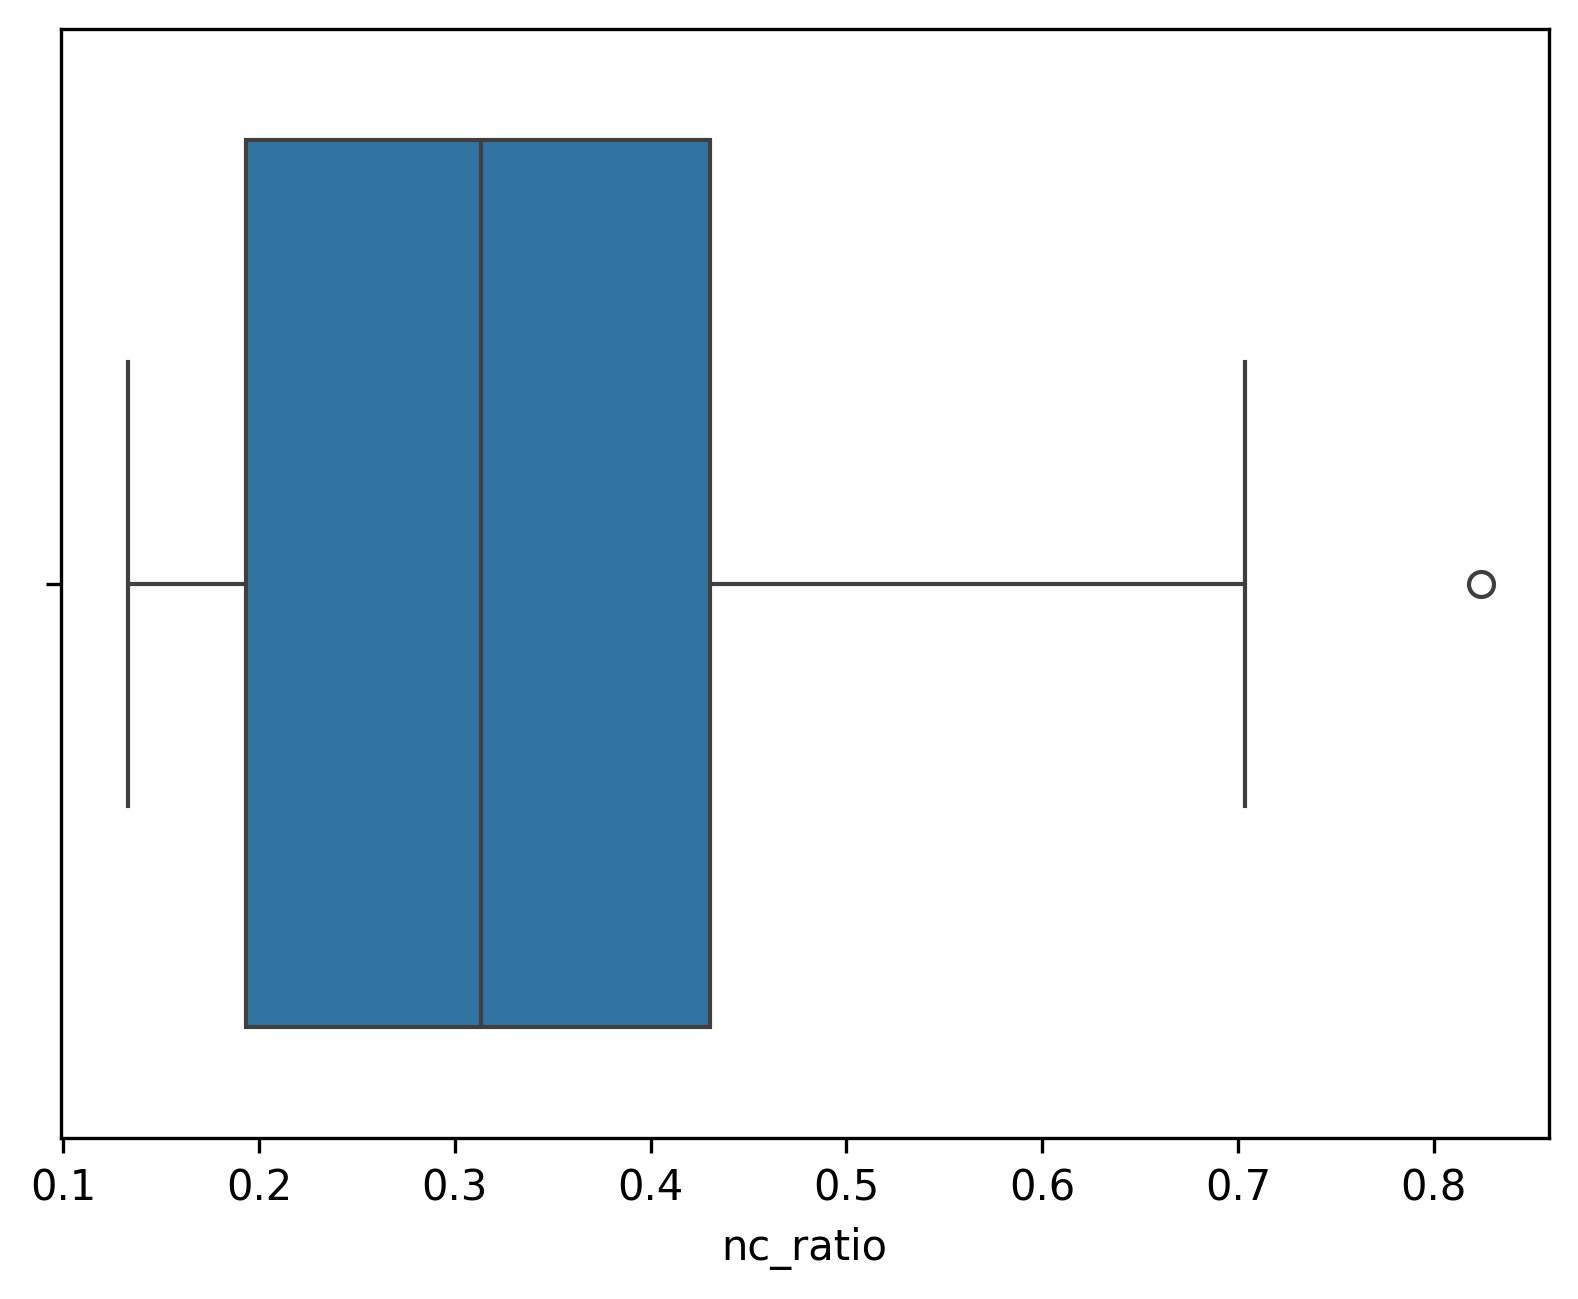

In [25]:
sns.boxplot(x=df["nc_ratio"])


In [26]:
from scipy.stats import shapiro, normaltest

shapiro(df["nc_ratio"])
normaltest(df["nc_ratio"])


NormaltestResult(statistic=np.float64(8.183455458096532), pvalue=np.float64(0.016710337667838634))

In [27]:
Q1 = df["nc_ratio"].quantile(0.25)
Q3 = df["nc_ratio"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["nc_ratio"] < lower_bound) | (df["nc_ratio"] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")



Number of outliers: 1


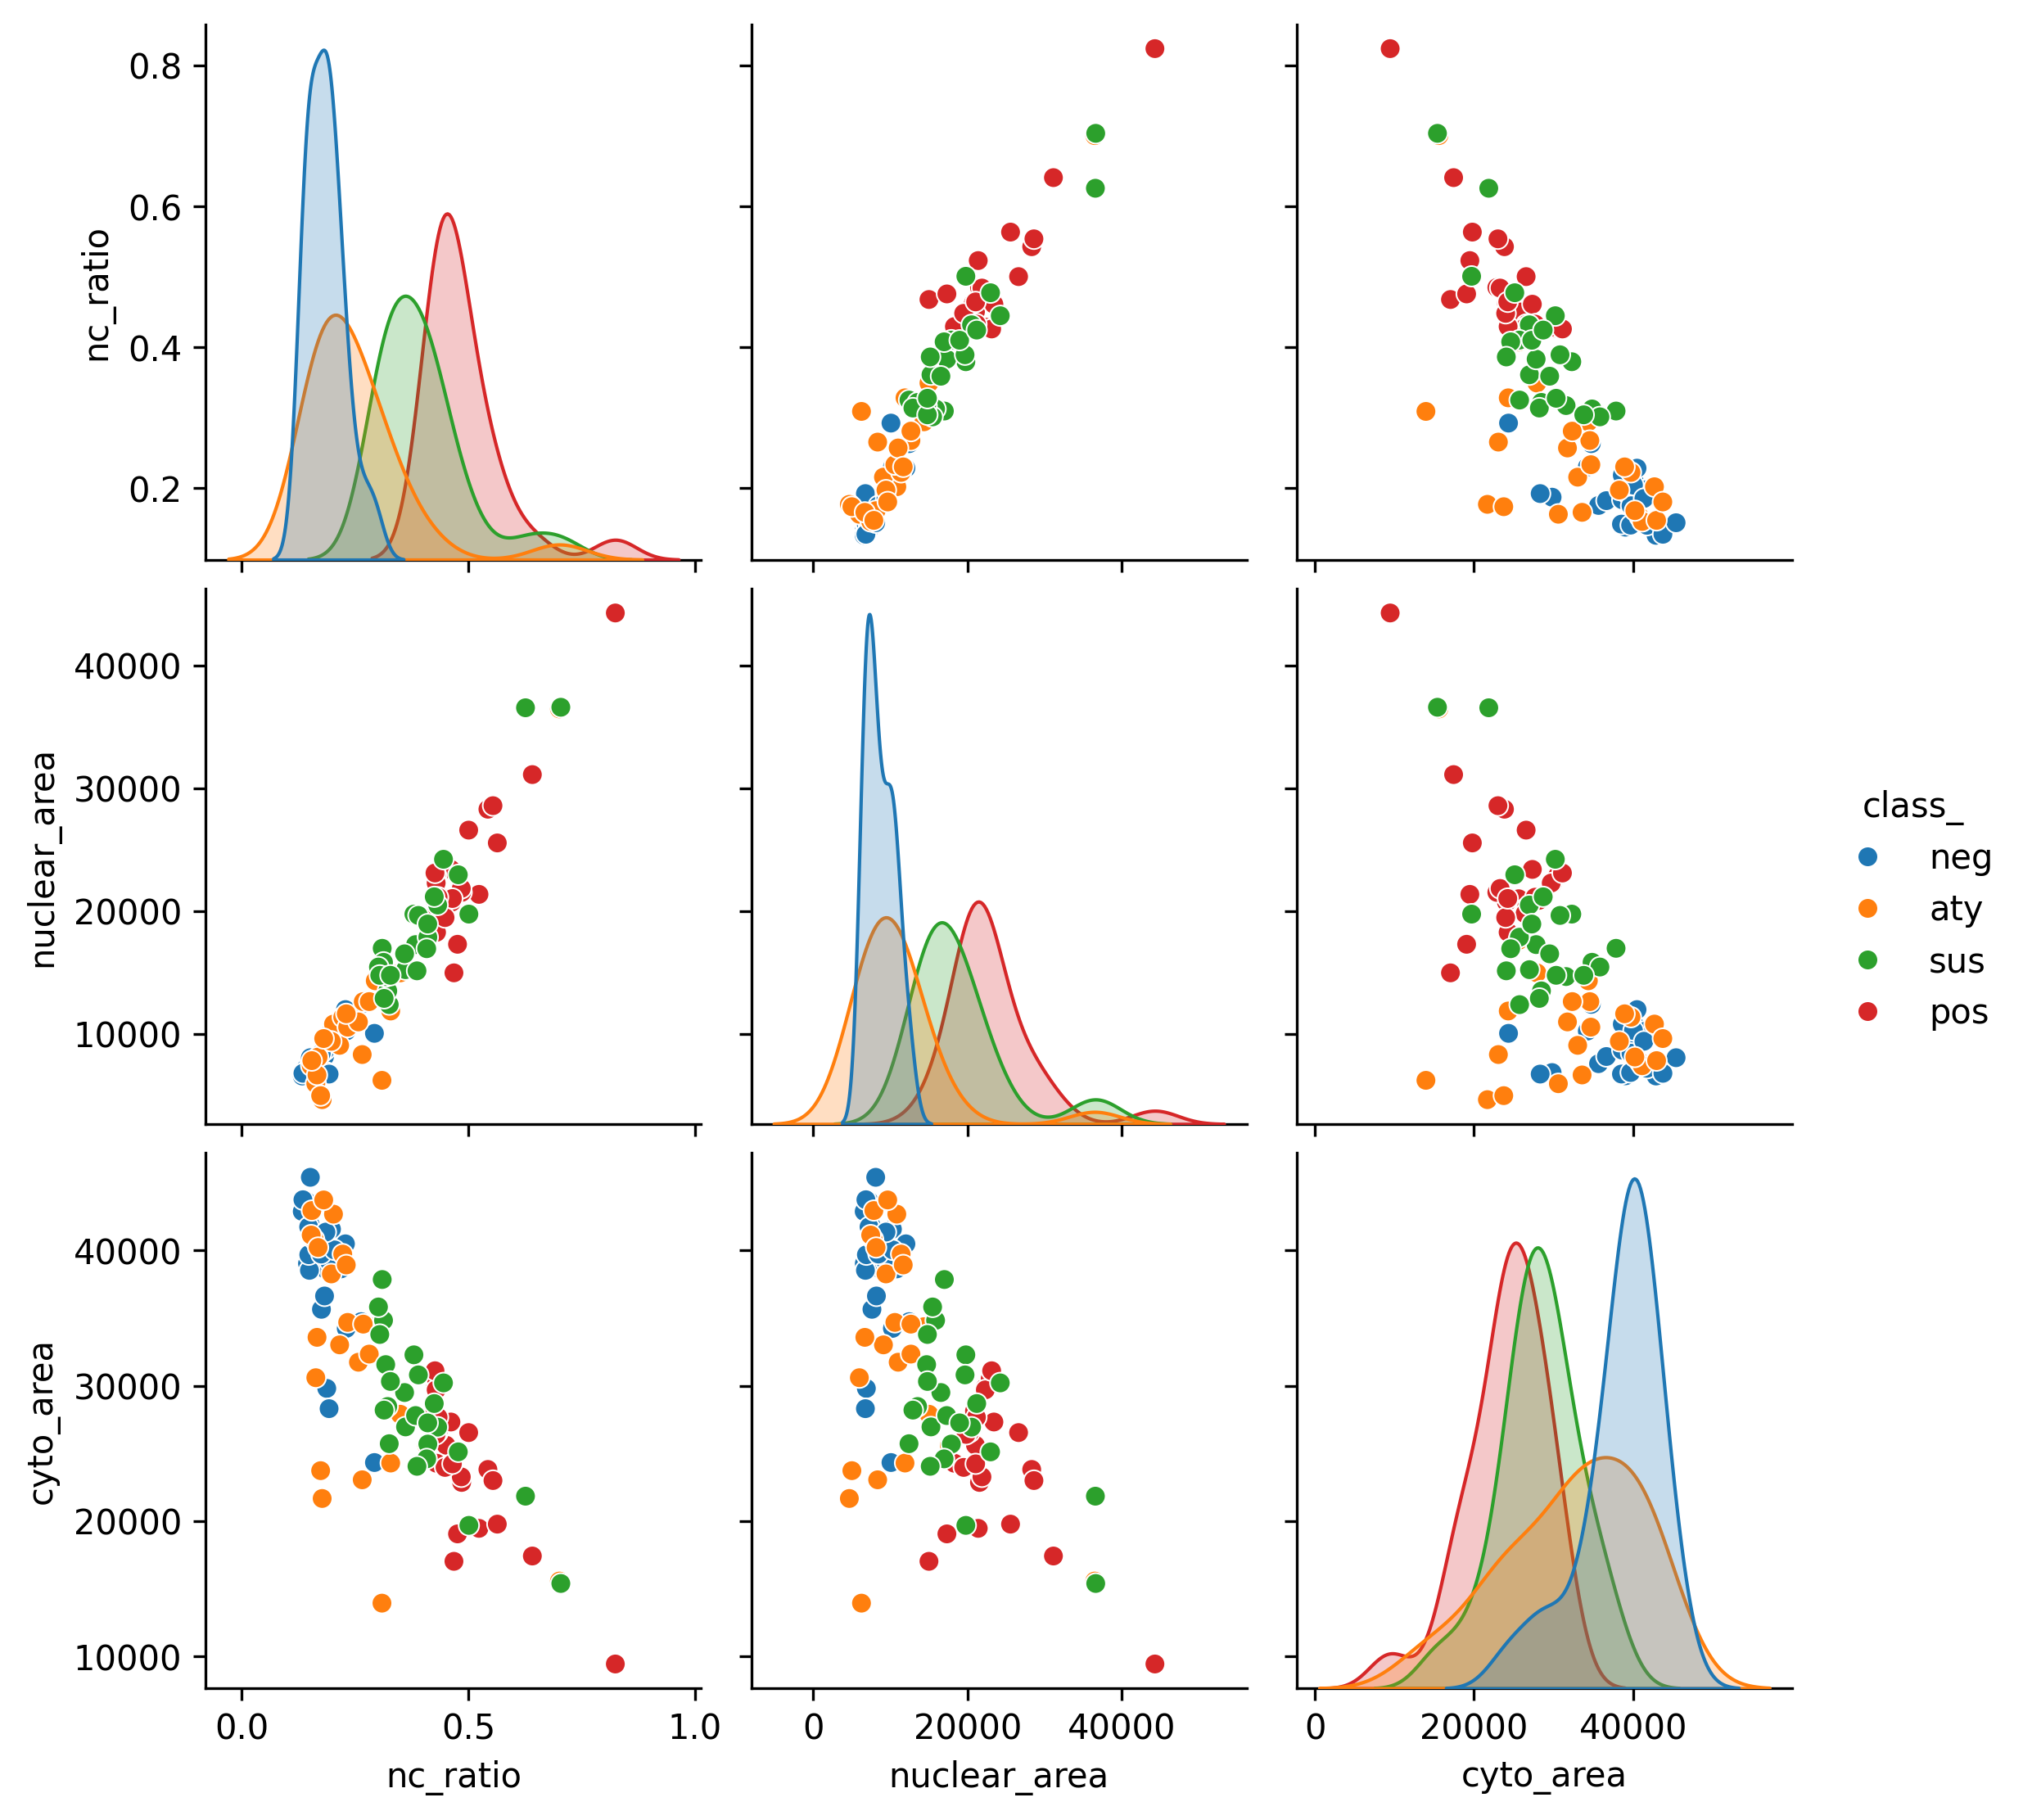

In [28]:
sns.pairplot(df, hue="class_", vars=["nc_ratio", "nuclear_area", "cyto_area"])


In [29]:
df[["nc_ratio", "nuclear_area", "cyto_area"]].corr()


,nc_ratio,nuclear_area,cyto_area
nc_ratio,1.000000,0.960601,-0.825265
nuclear_area,0.960601,1.000000,-0.663669
cyto_area,-0.825265,-0.663669,1.000000


In [30]:
from sklearn.decomposition import PCA
X = df[["nc_ratio", "nuclear_area", "cyto_area"]].values
X_pca = PCA(n_components=2).fit_transform(X)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from itertools import combinations
import pandas as pd

# Define feature options
features = ["aty","nc_ratio", "nuclear_area", "cyto_area"]
label = "class_"

# Store results
results = []

# Try all feature combinations: 1, 2, and 3 features
for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        X = df[list(combo)].values
        y = df[label].values

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

        # Normalize features (important for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Try both Random Forest and Logistic Regression
        for clf_name, clf in [
            ("Random Forest", RandomForestClassifier(random_state=42)),
            ("Logistic Regression", LogisticRegression(max_iter=1000))
        ]:
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)
            report = classification_report(y_test, y_pred, output_dict=True)
            accuracy = report["accuracy"]

            results.append({
                "features": combo,
                "classifier": clf_name,
                "accuracy": accuracy
            })

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print(results_df)



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                    features           classifier  accuracy
0                  (nuclear_area, cyto_area)  Logistic Regression      0.72
1                        (aty, nuclear_area)        Random Forest      0.68
2        (nc_ratio, nuclear_area, cyto_area)  Logistic Regression      0.68
3                      (nc_ratio, cyto_area)  Logistic Regression      0.68
4                   (nc_ratio, nuclear_area)  Logistic Regression      0.68
5                                (nc_ratio,)  Logistic Regression      0.64
6                   (nc_ratio, nuclear_area)        Random Forest      0.64
7             (aty, nuclear_area, cyto_area)        Random Forest      0.64
8        (nc_ratio, nuclear_area, cyto_area)        Random Forest      0.64
9              (aty, nc_ratio, nuclear_area)        Random Forest      0.64
10  (aty, nc_ratio, nuclear_area, cyto_area)        Random Forest      0.64
11                           (nuclear_area,)  Logistic Regression      0.60
12          

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from itertools import combinations
import pandas as pd

# Define features and label
features = [ "nc_ratio", "nuclear_area", "cyto_area"]
label = "class_"
classes = df[label].unique()
df[label] = pd.Categorical(df[label], categories=sorted(classes))  # ensure consistent ordering

results = []

# Try all combinations of 1 to N features
for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        X = df[list(combo)].values
        y = df[label].values

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

        # Normalize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Classifiers
        models = {
            "Random Forest": RandomForestClassifier(random_state=42),
            "Logistic Regression": LogisticRegression(max_iter=1000)
        }

        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)

            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

            # Multiclass AUROC using one-vs-rest
            y_bin = label_binarize(y_test, classes=model.classes_)
            auroc = roc_auc_score(y_bin, y_proba, multi_class="ovr", average="macro")

            results.append({
                "features": combo,
                "classifier": name,
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": report["weighted avg"]["precision"],
                "recall": report["weighted avg"]["recall"],
                "f1": report["weighted avg"]["f1-score"],
                "auroc": auroc
            })

# Display
results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print(results_df.round(3))

                               features           classifier  accuracy  \
0             (nuclear_area, cyto_area)  Logistic Regression      0.72   
1              (nc_ratio, nuclear_area)  Logistic Regression      0.68   
2                 (nc_ratio, cyto_area)  Logistic Regression      0.68   
3   (nc_ratio, nuclear_area, cyto_area)  Logistic Regression      0.68   
4                           (nc_ratio,)  Logistic Regression      0.64   
5   (nc_ratio, nuclear_area, cyto_area)        Random Forest      0.64   
6              (nc_ratio, nuclear_area)        Random Forest      0.64   
7                       (nuclear_area,)  Logistic Regression      0.60   
8                 (nc_ratio, cyto_area)        Random Forest      0.56   
9             (nuclear_area, cyto_area)        Random Forest      0.56   
10                         (cyto_area,)  Logistic Regression      0.48   
11                          (nc_ratio,)        Random Forest      0.44   
12                      (nuclear_area,

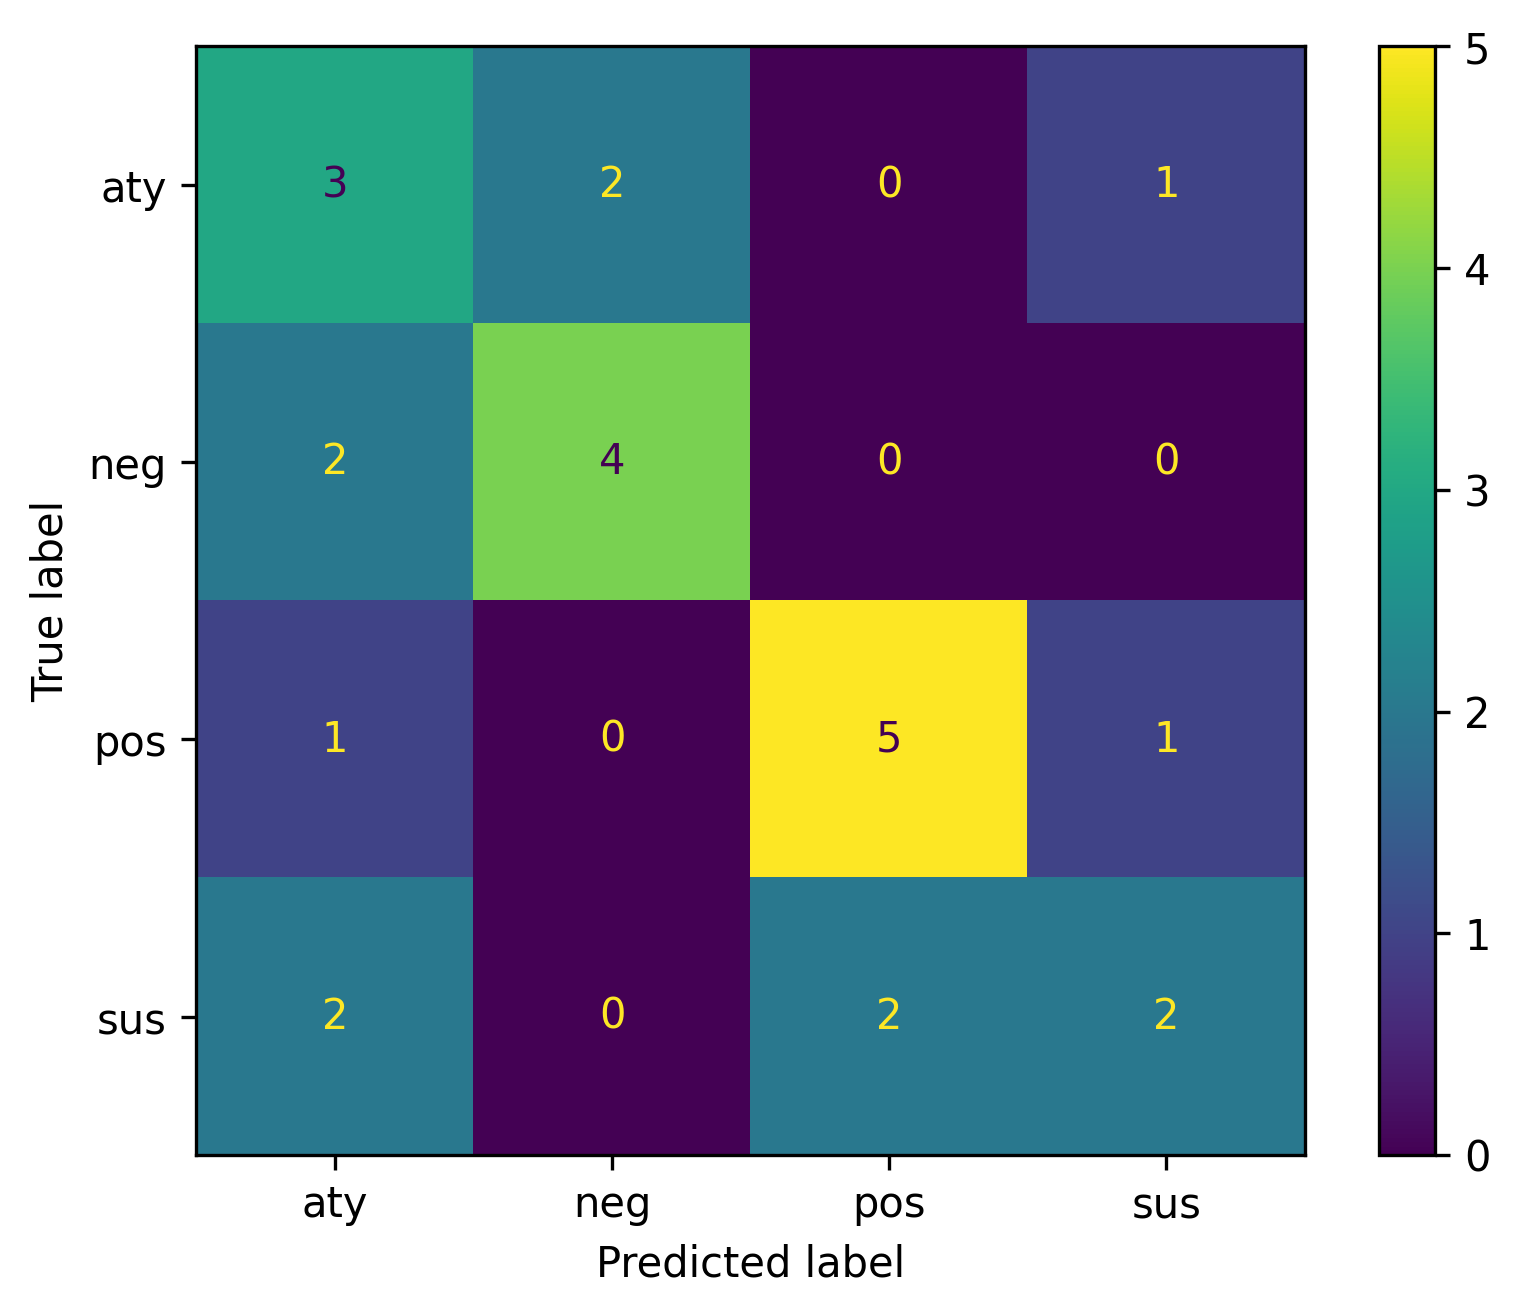

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from itertools import combinations
import pandas as pd

# Relabel
df["binary_class"] = df["class_"].apply(lambda x: 1 if x in ["pos", "sus"] else 0)
results = []

for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        X = df[list(combo)].values
        y = df["binary_class"].values

        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Models
        models = {
            "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000),
            "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42)
        }

        # Fit and evaluate
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]

            report = classification_report(y_test, y_pred, output_dict=True)
            auroc = roc_auc_score(y_test, y_proba)

            results.append({
                "features": combo,
                "classifier": name,
                "accuracy": report["accuracy"],
                "precision": report["1"]["precision"],
                "recall": report["1"]["recall"],
                "f1": report["1"]["f1-score"],
                "auroc": auroc
            })

# Sort and display
results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print(results_df.round(3))


                               features           classifier  accuracy  \
0                           (nc_ratio,)  Logistic Regression      0.96   
1                       (nuclear_area,)  Logistic Regression      0.96   
2                       (nuclear_area,)        Random Forest      0.96   
3                 (nc_ratio, cyto_area)  Logistic Regression      0.96   
4                          (cyto_area,)  Logistic Regression      0.92   
5                           (nc_ratio,)        Random Forest      0.92   
6             (nuclear_area, cyto_area)  Logistic Regression      0.92   
7              (nc_ratio, nuclear_area)  Logistic Regression      0.92   
8              (nc_ratio, nuclear_area)        Random Forest      0.92   
9                 (nc_ratio, cyto_area)        Random Forest      0.92   
10  (nc_ratio, nuclear_area, cyto_area)        Random Forest      0.92   
11  (nc_ratio, nuclear_area, cyto_area)  Logistic Regression      0.92   
12            (nuclear_area, cyto_area

In [35]:
from scipy.stats import pointbiserialr

# Convert binary class labels to 0/1
#df['binary_class_code'] = df['binary_class'].map({'non-positive': 0, 'positive': 1})

# Compute correlations
pb_corr = {}
for col in df.select_dtypes(include='number').drop(columns='binary_class'):
    corr_val, _ = pointbiserialr(df['binary_class'], df[col])
    pb_corr[col] = corr_val

# df
pb_corr_df = pd.DataFrame.from_dict(pb_corr, orient='index', columns=['PointBiserialCorr'])
pb_corr_df = pb_corr_df.sort_values(by='PointBiserialCorr', ascending=False)

print(pb_corr_df)


              PointBiserialCorr
nc_ratio               0.757634
nuclear_area           0.716667
aty                    0.375920
cyto_area             -0.582754


In [36]:
features = ["nc_ratio", "nuclear_area", "cyto_area"]
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [37]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results and class labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['class_'] = df['class_'].values


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from itertools import combinations
import pandas as pd

# Define feature options
features = ["nc_ratio", "nuclear_area", "cyto_area"]
label = "class_"

X = df[features].values
y = df[label].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (reduce to 2 or 3 components)
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Store results
results = []

for clf_name, clf in [
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000))
]:
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]

    results.append({
        "classifier": clf_name,
        "accuracy": accuracy
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


            classifier  accuracy
0        Random Forest      0.40
1  Logistic Regression      0.68


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from itertools import combinations
import pandas as pd

# Define feature options
features = ["nc_ratio", "nuclear_area", "cyto_area"]
label = "binary_class"

X = df[features].values
y = df[label].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (reduce to 2 or 3 components)
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Store results
results = []

for clf_name, clf in [
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000))
]:
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]

    results.append({
        "classifier": clf_name,
        "accuracy": accuracy
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


            classifier  accuracy
0        Random Forest      0.92
1  Logistic Regression      0.92


In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df[["nc_ratio", "nuclear_area", "cyto_area"]].values
y = df["class_"].values

selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X, y)

print(selector.scores_)  # higher score = more predictive


[58.19989775 41.01732099 25.57512955]
